# Estimation of MODIS-like Surface-Spectral Reflectance from Geostationary Satellites using Deep Neural Networks 

## Setup

In [1]:
%matplotlib inline
import argparse
import datetime
import glob
import os

import gdal
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = "8,8"
import scipy.ndimage
gdal.VersionInfo()

'2020200'

In [2]:
raw_dir = "modis"
layers = ["250m 16 days composite day of the year", # doy 1st for compositing reasons
          "250m 16 days NDVI", 
          "250m 16 days NIR reflectance"] 
raw_files = glob.glob(raw_dir + '/*.hdf')
raw_files[:5]

['modis/MOD13Q1.A2017257.h16v02.006.2017276133212.hdf',
 'modis/MOD13Q1.A2017257.h25v05.006.2017276133105.hdf',
 'modis/MOD13Q1.A2017257.h25v06.006.2017276132955.hdf',
 'modis/MOD13Q1.A2017273.h28v10.006.2017290090340.hdf',
 'modis/MOD13Q1.A2017257.h28v04.006.2017276133137.hdf']

In [3]:
filepath = [f for f in raw_files if 'h12v09' in f][0] # set day here
day_of_year = int(filepath.split('.')[4][4:7])
filepath, day_of_year

('modis/MOD13Q1.A2017257.h12v09.006.2017276132700.hdf', 276)

In [4]:
ds = gdal.Open(filepath, gdal.GA_ReadOnly)
datasets = ds.GetSubDatasets()
datasets[:2]

[('HDF4_EOS:EOS_GRID:"modis/MOD13Q1.A2017257.h12v09.006.2017276132700.hdf":MODIS_Grid_16DAY_250m_500m_VI:250m 16 days NDVI',
  '[4800x4800] 250m 16 days NDVI MODIS_Grid_16DAY_250m_500m_VI (16-bit integer)'),
 ('HDF4_EOS:EOS_GRID:"modis/MOD13Q1.A2017257.h12v09.006.2017276132700.hdf":MODIS_Grid_16DAY_250m_500m_VI:250m 16 days EVI',
  '[4800x4800] 250m 16 days EVI MODIS_Grid_16DAY_250m_500m_VI (16-bit integer)')]

## Day of Year

In [5]:
doy_layer = ""
for dataset in datasets:
    if layers[0] in dataset[0]:
        doy_layer = dataset[0]
file_type = doy_layer.split(' ')[3].lower()
doy_layer, file_type

('HDF4_EOS:EOS_GRID:"modis/MOD13Q1.A2017257.h12v09.006.2017276132700.hdf":MODIS_Grid_16DAY_250m_500m_VI:250m 16 days composite day of the year',
 'composite')

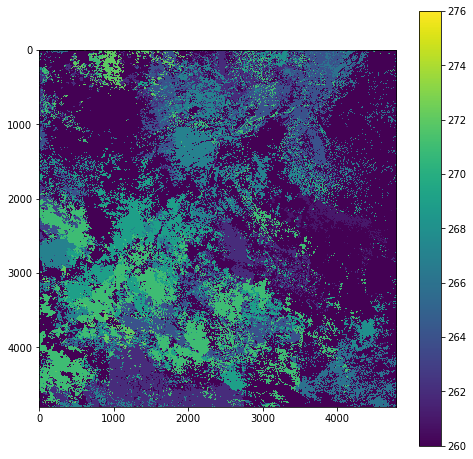

In [6]:
doy_modis = gdal.Open(doy_layer)
plt.imshow(doy_modis.ReadAsArray())
plt.clim(day_of_year - 16, day_of_year)
_ = plt.colorbar()

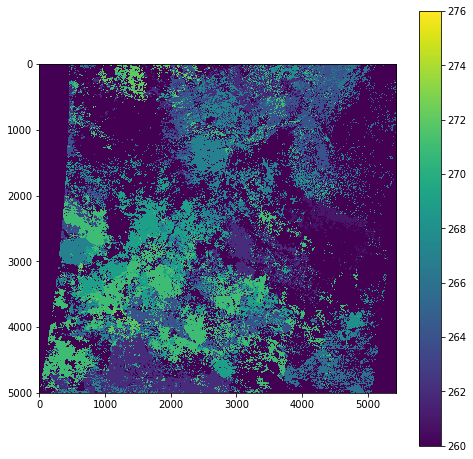

In [7]:
output = filepath.replace('.hdf', '.' + file_type + ".tif")
gdal.Warp(output, doy_modis, dstSRS='EPSG:3857')
data = gdal.Open(output)
doy_arr = data.ReadAsArray()
plt.imshow(doy_arr)
plt.clim(day_of_year - 16, day_of_year)
_ = plt.colorbar()


## Near Infrared

In [8]:
nir_layer = ""
for dataset in datasets:
    if layers[2] in dataset[0]:
        nir_layer = dataset[0]
        
file_type = nir_layer.split(' ')[3].lower()
nir_layer, file_type

('HDF4_EOS:EOS_GRID:"modis/MOD13Q1.A2017257.h12v09.006.2017276132700.hdf":MODIS_Grid_16DAY_250m_500m_VI:250m 16 days NIR reflectance',
 'nir')

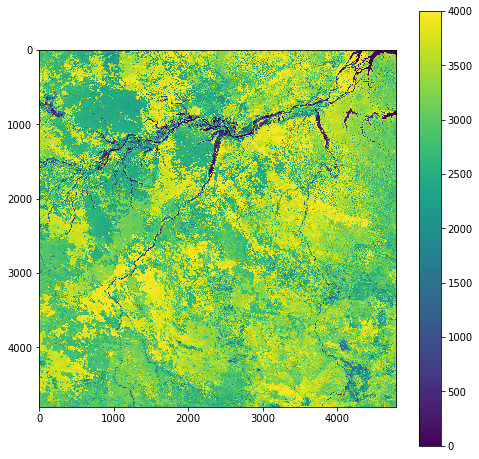

In [9]:
nir_modis = gdal.Open(nir_layer)
nir_modis.ReadAsArray()
plt.imshow(nir_modis.ReadAsArray())
plt.clim(0,4000)
_ = plt.colorbar()

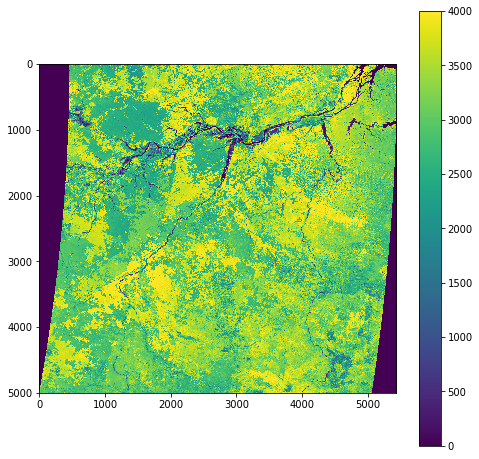

In [10]:
output = filepath.replace('.hdf', '.' + file_type + ".tif")
gdal.Warp(output, nir_modis, dstSRS='EPSG:3857')
data = gdal.Open(output)
nir_arr = data.ReadAsArray()
plt.imshow(nir_arr)
plt.clim(0,4000)
_ = plt.colorbar()

In [11]:
ulx, xres, xskew, uly, yskew, yres = nir_modis.GetGeoTransform()
lrx = ulx + (nir_modis.RasterXSize * xres)
lry = uly + (nir_modis.RasterYSize * yres)
xres, yres

(231.65635826395825, -231.65635826395834)

In [12]:
srs = nir_modis.GetProjection()
srs

'PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not specified (based on custom spheroid)",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1]]'

## GOES-16 NIR

In [13]:
doy = int(filepath.split('.')[1][5:])
year = int(filepath.split('.')[4][0:4])
date = datetime.datetime(year, 1, 1) + datetime.timedelta(doy - 1)
doy

257

In [14]:
from netCDF4 import Dataset

In [15]:
goes_dir = "goes"
preprocessed = False
if not preprocessed:
    veggies = ['NETCDF:' + f + ':Rad' for f in sorted(glob.glob(goes_dir + '/' + str(doy) + '/18/*M3C03*.nc'))] # sort
else:
    veggies = sorted(glob.glob(goes_dir + '/' + str(doy) + '/18/t*M3C03*.nc')) # sort
veggies[:3]

['NETCDF:goes/257/18/OR_ABI-L1b-RadF-M3C03_G16_s20172571800379_e20172571811146_c20172571811197.nc:Rad',
 'NETCDF:goes/257/18/OR_ABI-L1b-RadF-M3C03_G16_s20172571815379_e20172571826146_c20172571826188.nc:Rad',
 'NETCDF:goes/257/18/OR_ABI-L1b-RadF-M3C03_G16_s20172571830379_e20172571841146_c20172571841193.nc:Rad']

$\uparrow$ These are the GOES-16 Veggie/NIR Band (band 3) files at 1 km resolution

In [16]:
if not preprocessed:
    red = ['NETCDF:' + f + ':Rad' for f in sorted(glob.glob(goes_dir + '/' + str(doy) + '/18/*M3C02*.nc'))] # sort
else:
    red = sorted(glob.glob(goes_dir + '/' + str(doy) + '/18/t*M3C02*.nc')) # sort
red[:3]

['NETCDF:goes/257/18/OR_ABI-L1b-RadF-M3C02_G16_s20172571800379_e20172571811146_c20172571811182.nc:Rad',
 'NETCDF:goes/257/18/OR_ABI-L1b-RadF-M3C02_G16_s20172571815379_e20172571826146_c20172571826178.nc:Rad',
 'NETCDF:goes/257/18/OR_ABI-L1b-RadF-M3C02_G16_s20172571830379_e20172571841146_c20172571841188.nc:Rad']

$\uparrow$ These are the GOES-16 Red Band (band 2) files at 0.5 km resolution

In [17]:
# f = goes_files[1]
translated = glob.glob(goes_dir + '/' + str(doy) + '/18/*M3C02*')
goes_net = Dataset(veggies[3].split(':')[1], "r", format="NETCDF4")
goes_arr = goes_net['Rad'][:].data

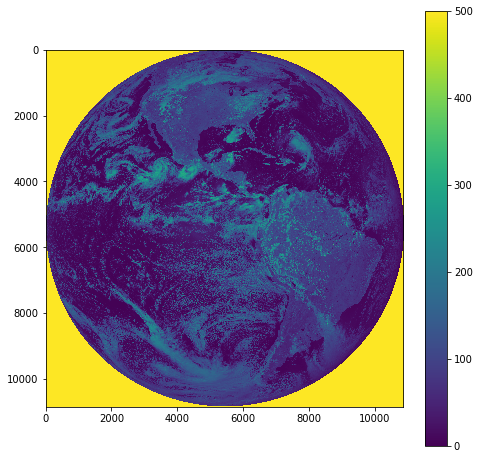

In [18]:
plt.imshow(goes_arr)
plt.clim(0,500)
_ = plt.colorbar()

In [19]:
b = gdal.Open(veggies[3])
wkt = b.GetProjection()
wkt

'PROJCS["unnamed",GEOGCS["unknown",DATUM["unknown",SPHEROID["Spheroid",6378137,298.2572221]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Geostationary_Satellite"],PARAMETER["central_meridian",-89.5],PARAMETER["satellite_height",35786023],PARAMETER["false_easting",0],PARAMETER["false_northing",0],EXTENSION["PROJ4","+proj=geos +lon_0=-89.5 +h=35786023 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs  +sweep=x"]]'

In [20]:
veggies[3]

'NETCDF:goes/257/18/OR_ABI-L1b-RadF-M3C03_G16_s20172571845379_e20172571856146_c20172571856196.nc:Rad'

In [21]:
def warp(outputfn, inputfn, dstSRS='EPSG:3857'):
    os.system('gdalwarp -t_srs "{}" {} {}'.format(dstSRS, inputfn, outputfn))
    return gdal.Open(outputfn)
t = gdal.Warp('test5.tif', veggies[3], dstSRS='EPSG:3857')
t.GetProjection()

'PROJCS["WGS 84 / Pseudo-Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Mercator_1SP"],PARAMETER["central_meridian",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["X",EAST],AXIS["Y",NORTH],EXTENSION["PROJ4","+proj=merc +a=6378137 +b=6378137 +lat_ts=0.0 +lon_0=0.0 +x_0=0.0 +y_0=0 +k=1.0 +units=m +nadgrids=@null +wktext +no_defs"],AUTHORITY["EPSG","3857"]]'

In [22]:
cut = gdal.Warp('cutout.tif', t, outputBoundsSRS=srs, outputBounds=[ulx, lry, lrx, uly])
culx, cxres, cxskew, culy, cyskew, cyres = cut.GetGeoTransform()
xres, cxres
xres / cxres

0.10894915764183315

/usr/local/lib/python2.7/dist-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


(526, 572) (5000, 5435)
Ratio:  0.108949157642


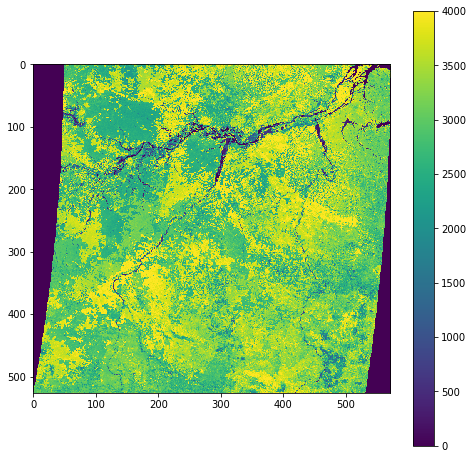

In [23]:
# resize using nn
resized_nir = scipy.ndimage.zoom(nir_arr, data.GetGeoTransform()[1] / cxres, order=0)
print resized_nir.shape, nir_arr.shape
plt.imshow(resized_nir)
plt.clim(0,4000)
_ = plt.colorbar()
print 'Ratio: ', xres / cxres

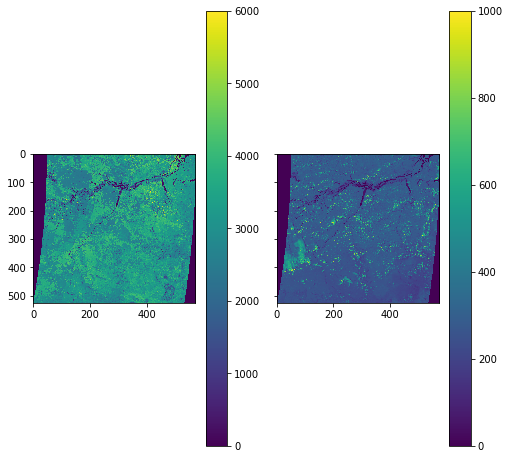

In [24]:
cutout_arr = cut.ReadAsArray()
s = cutout_arr.shape
cutout_arr[resized_nir == -1000] = -1000 # set the same nodata ranges

f, ax = plt.subplots(1, 2)
ax[1].set_yticklabels([])

a = ax[0].imshow(resized_nir)
a.set_clim(vmin=0, vmax=6000)

b = ax[1].imshow(cutout_arr)
b.set_clim(vmin=0, vmax=1000)

_ = f.colorbar(a, ax=ax[0])
_ = f.colorbar(b, ax=ax[1])


# Implementation

In [25]:
# Find closest goes-16 times
modis_time = filepath.split('.')[4][7:]
_time = datetime.datetime.strptime(modis_time, "%H%M%S")
if _time.minute % 15 > 7:
    _time += datetime.timedelta(minutes=15 - (_time.minute % 15))
else:
    _time += datetime.timedelta(minutes=-_time.minute % 15)
timendate = datetime.datetime.combine(date.date(), _time.time())
timendate.strftime('%Y-%m-%d %H:%M')
timendate

datetime.datetime(2017, 9, 14, 13, 30)

In [26]:
timendate.timetuple().tm_yday

257

In [27]:
goes_dict = {}
for day in range(timendate.timetuple().tm_yday, timendate.timetuple().tm_yday + 16):
    goes_selected = sorted(glob.glob('goes/{}/{}/O*C03*.nc'.format(day, timendate.hour)))
    if len(goes_selected) < 1:
        os.system('aws s3 sync s3://noaa-goes16/ABI-L1b-RadF/2017/{}/ goes/{}/ --exclude "*" --include "*M3C03_*2017{}{}*"'.format(day, day, day,
                                                                                                                           timendate.strftime('%H%M')))
    goes_selected = sorted(glob.glob('goes/{}/{}/O*C03*.nc'.format(day, timendate.hour)))
    goes_selected
    temp = []
    for i, fi in enumerate(goes_selected):
        f = os.path.basename(fi)
        gtime = f[34:38]
        ftime = datetime.datetime.strptime(gtime, '%H%M')
        if ftime.hour == timendate.hour and ftime.minute == timendate.minute:
            temp.append(fi)
    goes_dict[day] = temp
goes_dict

{257: ['goes/257/13/OR_ABI-L1b-RadF-M3C03_G16_s20172571330382_e20172571341149_c20172571341195.nc'],
 258: ['goes/258/13/OR_ABI-L1b-RadF-M3C03_G16_s20172581330379_e20172581341146_c20172581341188.nc'],
 259: ['goes/259/13/OR_ABI-L1b-RadF-M3C03_G16_s20172591330380_e20172591341147_c20172591341196.nc'],
 260: ['goes/260/13/OR_ABI-L1b-RadF-M3C03_G16_s20172601330386_e20172601341152_c20172601341198.nc'],
 261: ['goes/261/13/OR_ABI-L1b-RadF-M3C03_G16_s20172611330393_e20172611341159_c20172611341208.nc'],
 262: ['goes/262/13/OR_ABI-L1b-RadF-M3C03_G16_s20172621330400_e20172621341167_c20172621341215.nc'],
 263: ['goes/263/13/OR_ABI-L1b-RadF-M3C03_G16_s20172631330407_e20172631341174_c20172631341224.nc'],
 264: ['goes/264/13/OR_ABI-L1b-RadF-M3C03_G16_s20172641330413_e20172641341180_c20172641341228.nc'],
 265: ['goes/265/13/OR_ABI-L1b-RadF-M3C03_G16_s20172651330419_e20172651341186_c20172651341234.nc'],
 266: ['goes/266/13/OR_ABI-L1b-RadF-M3C03_G16_s20172661330425_e20172661341192_c20172661341238.nc'],


In [28]:
shape = resized_nir.shape
matrix = np.zeros((shape[0], shape[1], 16))

(526, 572) (5000, 5435)
Ratio:  0.108949157642


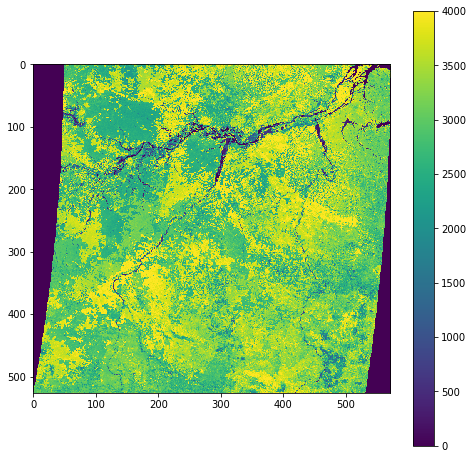

In [29]:
# resize using nn
resized_nir = scipy.ndimage.zoom(nir_arr, data.GetGeoTransform()[1] / cxres, order=0)
print resized_nir.shape, nir_arr.shape
plt.imshow(resized_nir)
plt.clim(0,4000)
_ = plt.colorbar()
print 'Ratio: ', xres / cxres

In [39]:
test_run = False
for i, day in enumerate(goes_dict):
    if len(goes_dict[day]) > 0:
        f = goes_dict[day][0] # veggie NIR
        output = os.path.dirname(f) + '/' + os.path.basename(f).split('.')[0] + '.tif'

        if not os.path.isfile(output):
            t = gdal.Warp(output, 'NETCDF:' + f + ':Rad', dstSRS='EPSG:3857')
            print output
        else:
            t = gdal.Open(output)
        cut = gdal.Warp('cutout.tif', t, outputBoundsSRS=srs, outputBounds=[ulx, lry, lrx, uly])
        culx, cxres, cxskew, culy, cyskew, cyres = cut.GetGeoTransform()
        arr = cut.ReadAsArray()
        if test_run:
            for x in range(16):
                matrix[:, :, x] = arr
            break
        else:
            matrix[:, :, i] = arr

(526, 572) (5000, 5435)
Ratio:  0.108949157642


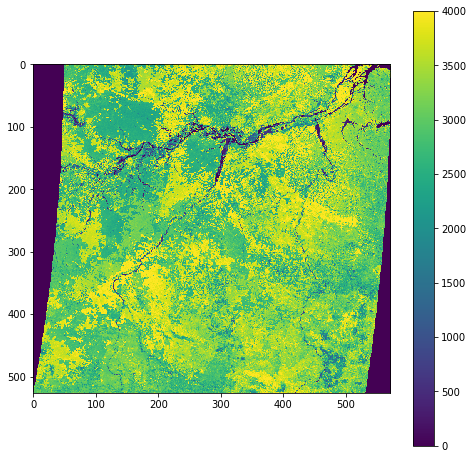

In [40]:
# resize using nn
resized_nir = scipy.ndimage.zoom(nir_arr, data.GetGeoTransform()[1] / cxres, order=0)
print resized_nir.shape, nir_arr.shape
plt.imshow(resized_nir)
plt.clim(0,4000)
_ = plt.colorbar()
print 'Ratio: ', xres / cxres

In [41]:
for layer in range(16):
    matrix[:, :, layer][resized_nir == -1000] = -1000

Ratio:  0.108949157642


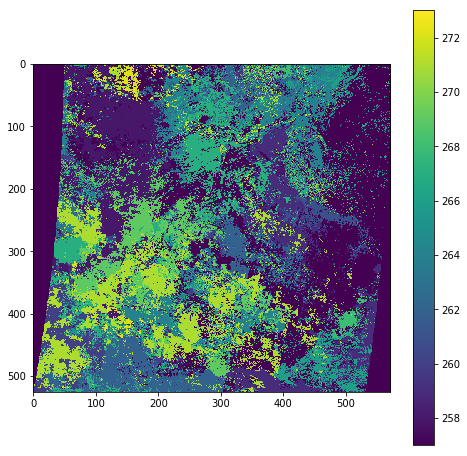

In [44]:
# Resize doy array
# resize using nn
resized_doy = scipy.ndimage.zoom(doy_arr, data.GetGeoTransform()[1] / cxres, order=0)
plt.imshow(resized_doy)
plt.clim(doy, doy+16)
_ = plt.colorbar()
print 'Ratio: ', xres / cxres

In [45]:
i, j = np.ogrid[:shape[0], :shape[1]]
resized_doy -= doy
resized_doy = resized_doy.clip(min=0)
composite = matrix[i, j, resized_doy]

In [46]:
composite

array([[-1000., -1000., -1000., ..., -1000.,   246.,   267.],
       [-1000., -1000., -1000., ..., -1000., -1000.,   237.],
       [-1000., -1000., -1000., ..., -1000., -1000.,   239.],
       ..., 
       [-1000.,   199.,   196., ..., -1000., -1000., -1000.],
       [-1000.,   196.,   193., ..., -1000., -1000., -1000.],
       [  188.,   190.,   191., ..., -1000., -1000., -1000.]])

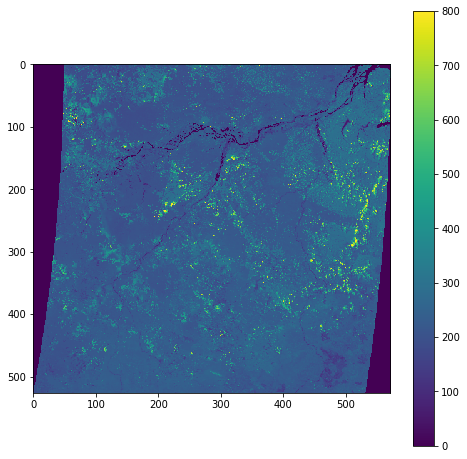

In [47]:
plt.imshow(composite);
plt.colorbar()
plt.clim(0, 800)

In [48]:
def array_to_raster_w_source(dst_filename, array, source):
    """Array > Raster
    Save a raster from a C order array using another dataset as source.

    :param array: ndarray
    """
    driver = gdal.GetDriverByName('GTiff')

    dataset = driver.Create(
        dst_filename,
        array.shape[1],
        array.shape[0],
        1,
        gdal.GDT_Float32, )

    dataset.SetGeoTransform(source.GetGeoTransform())  


    dataset.GetRasterBand(1).WriteArray(array)
    dataset.GetRasterBand(1).SetNoDataValue(-1000)##if you want these values transparent
    dataset.SetGeoTransform(source.GetGeoTransform())
    dataset.SetProjection(source.GetProjection())
    dataset.FlushCache()  # Write to disk.
    
array_to_raster_w_source('finished.tif', composite, cut) # use the cutout for proper resolution